# 03: M1/S1 - Unsupervised Anomaly Detection (Token Level)

**Goal:** Detect subjective words (LJMPNIK) using unsupervised methods (Mahalanobis, Isolation Forest, OCSVM).

## 1. Setup & Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from itables import show
import sys
import os
from tqdm.notebook import tqdm

from sklearn.metrics import precision_recall_curve, auc

# Auto-reload modules for development
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Add src to path
current_dir = os.getcwd()
src_dir = os.path.abspath(os.path.join(current_dir, '..', 'src'))
if src_dir not in sys.path:
    sys.path.append(src_dir)

# Import custom modules
import config
import data_splitting
import models
import visualization
import experiments
import evaluation


# Setup visualization style
visualization.setup_style()

print(f"✅ Setup complete. Data dir: {config.DATA_DIR}")


⚙️ Configuration loaded. Device: cpu


2026-02-03 23:26:28,447 - INFO - 🎨 Visualization style set: whitegrid


✅ Setup complete. Data dir: C:\Users\dobes\Documents\UniversityCodingProject\ThesisCoding\data


## 2. Data Check

In [2]:
# Load sample data (Aggressive filter) just to check stats

data_sample = data_splitting.get_unsupervised_splits(
    scenario='baseline', 
    level='token', 
    filter_type='aggressive'
)

print(f"🔹 TRAIN set (Neutral only): {data_sample['X_train'].shape}")
print(f"🔹 VAL set (Mixed):          {data_sample['X_val'].shape}")
print(f"🔹 TEST set (Mixed):         {data_sample['X_test'].shape}")

# Verify Train contains only L0
train_anomalies = data_sample['y_train'].sum()
print(f"⚠️ Anomalies in Train: {train_anomalies} (Should be 0)")


2026-02-03 23:26:35,912 - INFO - 🔄 Preparing UNSUPERVISED splits for scenario: baseline
2026-02-03 23:26:35,913 - INFO - 📊 Preparing scenario: baseline (token level, aggressive filter)
2026-02-03 23:26:36,617 - INFO - ✅ Loaded 17557 rows from C:\Users\dobes\Documents\UniversityCodingProject\ThesisCoding\data\processed\gold_tokens.pkl
2026-02-03 23:26:39,863 - INFO - ✅ Loaded 78991 rows from C:\Users\dobes\Documents\UniversityCodingProject\ThesisCoding\data\processed\silver_tokens.pkl
2026-02-03 23:26:39,964 - INFO - Splitting 520 documents: 104 test, 41 val, 375 train
2026-02-03 23:26:39,978 - INFO - ✅ Document-level split completed:
2026-02-03 23:26:39,978 - INFO -    Train: 376 docs, 2585 samples
2026-02-03 23:26:39,978 - INFO -    Val:   41 docs, 270 samples
2026-02-03 23:26:39,985 - INFO -    Test:  103 docs, 741 samples
2026-02-03 23:26:39,985 - INFO -    ✓ No document leakage detected between splits
2026-02-03 23:26:39,985 - INFO - ✅ Scenario data prepared:
2026-02-03 23:26:39,99

🔹 TRAIN set (Neutral only): (900, 768)
🔹 VAL set (Mixed):          (270, 768)
🔹 TEST set (Mixed):         (741, 768)
⚠️ Anomalies in Train: 0 (Should be 0)


## 3. Experimental Loop

In [3]:
SCENARIOS = ['baseline', 'robustness']
FILTERS = ['aggressive', 'mild']
RESULTS_PATH = config.RESULTS_DIR / "M1_S1_experiment_results_v3_.csv"

# Grid parametrů
PARAM_GRID = {
    'Mahalanobis': [
        {'method': 'empirical'},
        {'method': 'robust'}  
    ],
    'IsolationForest': [
        {'n_estimators': 100, 'max_samples': 'auto'},
        {'n_estimators': 200, 'max_samples': 'auto'},
        {'n_estimators': 100, 'max_samples': 0.8},
    ],
    'OCSVM': [
        {'nu': 0.01, 'kernel': 'rbf', 'gamma': 'scale'},
        {'nu': 0.05, 'kernel': 'rbf', 'gamma': 'scale'},
        {'nu': 0.10, 'kernel': 'rbf', 'gamma': 'scale'},
        {'nu': 0.05, 'kernel': 'rbf', 'gamma': 0.1},
    ]
}

# Sloupce pro výsledné CSV
columns = [
    'scenario', 'filter', 'model', 'params', 
    'val_f1', 'val_threshold', # Důležité: Práh vybraný na validaci
    'test_f1', 'test_precision', 'test_recall', 'test_roc_auc', 'test_auprc'
]

In [ ]:
%%script false          # Buňka je přeskočena, ať netrénujeme pokaždé. 

# Příprava souboru (pokud neexistuje, vytvoříme hlavičku)
if RESULTS_PATH.exists():
    print(f"⚠️ Soubor {RESULTS_PATH.name} již existuje. Připojuji výsledky...")
else:
    pd.DataFrame(columns=columns).to_csv(RESULTS_PATH, index=False)
    print(f"🆕 Vytvořen nový soubor: {RESULTS_PATH.name}")

# --- HLAVNÍ SMYČKA ---
print(f"🚀 SPUŠTĚNÍ EXPERIMENTŮ (Hybrid v2/v3 style)")

for scenario in SCENARIOS:
    print(f"\n{'='*60}")
    print(f"🌍 SCÉNÁŘ: {scenario.upper()}")
    print(f"{'='*60}")
    
    for filter_type in FILTERS:
        print(f"\n  ⚙️ Filter: {filter_type.upper()}")
        
        # 1. NAČTENÍ DAT (Jednou pro daný filtr/scénář) - Používáme bezpečný modul!
        try:
            data = data_splitting.get_unsupervised_splits(
                scenario=scenario,
                level='token',
                filter_type=filter_type,
                pooling='mean', # U token level ignorováno
                random_state=42
            )
            X_train = data['X_train'] # L0 only
            X_val = data['X_val']     # Mixed
            y_val = data['y_val']
            X_test = data['X_test']   # Mixed (Gold or Hybrid)
            y_test = data['y_test']
            
            print(f"      -> Data OK: Train={X_train.shape[0]}, Val={X_val.shape[0]}, Test={X_test.shape[0]}")
            
        except Exception as e:
            print(f"      ❌ CHYBA při načítání dat: {e}")
            continue

        # 2. SMYČKA MODELŮ
        for model_name, params_list in PARAM_GRID.items():
            
            # Progress bar pro parametry daného modelu
            for params in tqdm(params_list, desc=f"      Running {model_name}", leave=False):
                try:
                    # A. Init & Train (Učíme se jen na X_train - normalita)
                    clf = models.get_unsupervised_model(model_name, **params)
                    clf.fit(X_train)
                    
                    # B. Validation (Hledáme práh na X_val)
                    # Toto je ten metodologický rozdíl oproti v2! 
                    # Práh nesmíme hledat na Test datech.
                    scores_val = clf.decision_function(X_val)
                    best_thresh, best_val_f1 = evaluation.find_optimal_threshold(
                        y_val, scores_val, metric='f1'
                    )
                    
                    # C. Testing (Aplikujeme práh na X_test)
                    scores_test = clf.decision_function(X_test)
                    y_pred_test = (scores_test > best_thresh).astype(int)
                    
                    # D. Metriky
                    metrics = evaluation.calculate_metrics(y_test, y_pred_test, scores_test)
                    
                    # Spočítáme AUPRC (Area Under Precision-Recall Curve) ručně, je to fajn metrika
                    precision_curve, recall_curve, _ = precision_recall_curve(y_test, scores_test)
                    test_auprc = auc(recall_curve, precision_curve)
                    
                    # E. Uložení
                    result_row = {
                        'scenario': scenario,
                        'filter': filter_type,
                        'model': model_name,
                        'params': str(params),
                        'val_f1': best_val_f1,
                        'val_threshold': best_thresh,
                        'test_f1': metrics['f1'],
                        'test_precision': metrics['precision'],
                        'test_recall': metrics['recall'],
                        'test_roc_auc': metrics.get('roc_auc', 0), # Ošetřeno v evaluation.py
                        'test_auprc': test_auprc
                    }
                    
                    # Append to CSV
                    pd.DataFrame([result_row]).to_csv(RESULTS_PATH, mode='a', header=False, index=False)
                    
                except Exception as e:
                    print(f"      ⚠️ Chyba u {model_name} {params}: {e}")
                    continue

print(f"\n✅ HOTOVO! Výsledky uloženy v {RESULTS_PATH}")
# Zobrazení výsledků
results = pd.read_csv(RESULTS_PATH)


2026-02-03 22:45:53,175 - INFO - 🔄 Preparing UNSUPERVISED splits for scenario: baseline
2026-02-03 22:45:53,192 - INFO - 📊 Preparing scenario: baseline (token level, aggressive filter)


🆕 Vytvořen nový soubor: M1_S1_experiment_results_v3_.csv
🚀 SPUŠTĚNÍ EXPERIMENTŮ (Hybrid v2/v3 style)

🌍 SCÉNÁŘ: BASELINE

  ⚙️ Filter: AGGRESSIVE


2026-02-03 22:45:54,176 - INFO - ✅ Loaded 17557 rows from C:\Users\dobes\Documents\UniversityCodingProject\ThesisCoding\data\processed\gold_tokens.pkl
2026-02-03 22:45:58,975 - INFO - ✅ Loaded 78991 rows from C:\Users\dobes\Documents\UniversityCodingProject\ThesisCoding\data\processed\silver_tokens.pkl
2026-02-03 22:45:59,067 - INFO - Splitting 520 documents: 104 test, 41 val, 375 train
2026-02-03 22:45:59,090 - INFO - ✅ Document-level split completed:
2026-02-03 22:45:59,091 - INFO -    Train: 376 docs, 2585 samples
2026-02-03 22:45:59,091 - INFO -    Val:   41 docs, 270 samples
2026-02-03 22:45:59,091 - INFO -    Test:  103 docs, 741 samples
2026-02-03 22:45:59,091 - INFO -    ✓ No document leakage detected between splits
2026-02-03 22:45:59,091 - INFO - ✅ Scenario data prepared:
2026-02-03 22:45:59,091 - INFO -    Train: 2585 samples (L0: 900, L1: 1685)
2026-02-03 22:45:59,102 - INFO -    Val:   270 samples (L0: 96, L1: 174)
2026-02-03 22:45:59,104 - INFO -    Test:  741 samples (L0

      -> Data OK: Train=900, Val=270, Test=741


      Running Mahalanobis:   0%|          | 0/2 [00:00<?, ?it/s]

      Running IsolationForest:   0%|          | 0/3 [00:00<?, ?it/s]

      Running OCSVM:   0%|          | 0/4 [00:00<?, ?it/s]

2026-02-03 22:50:33,370 - INFO - 🔄 Preparing UNSUPERVISED splits for scenario: baseline
2026-02-03 22:50:33,386 - INFO - 📊 Preparing scenario: baseline (token level, mild filter)



  ⚙️ Filter: MILD


2026-02-03 22:50:34,073 - INFO - ✅ Loaded 17557 rows from C:\Users\dobes\Documents\UniversityCodingProject\ThesisCoding\data\processed\gold_tokens.pkl
2026-02-03 22:50:37,282 - INFO - ✅ Loaded 78991 rows from C:\Users\dobes\Documents\UniversityCodingProject\ThesisCoding\data\processed\silver_tokens.pkl
2026-02-03 22:50:37,349 - INFO - Splitting 520 documents: 104 test, 41 val, 375 train
2026-02-03 22:50:37,377 - INFO - ✅ Document-level split completed:
2026-02-03 22:50:37,379 - INFO -    Train: 376 docs, 2654 samples
2026-02-03 22:50:37,379 - INFO -    Val:   41 docs, 278 samples
2026-02-03 22:50:37,381 - INFO -    Test:  103 docs, 755 samples
2026-02-03 22:50:37,384 - INFO -    ✓ No document leakage detected between splits
2026-02-03 22:50:37,384 - INFO - ✅ Scenario data prepared:
2026-02-03 22:50:37,384 - INFO -    Train: 2654 samples (L0: 918, L1: 1736)
2026-02-03 22:50:37,384 - INFO -    Val:   278 samples (L0: 97, L1: 181)
2026-02-03 22:50:37,384 - INFO -    Test:  755 samples (L0

      -> Data OK: Train=918, Val=278, Test=755


      Running Mahalanobis:   0%|          | 0/2 [00:00<?, ?it/s]

      Running IsolationForest:   0%|          | 0/3 [00:00<?, ?it/s]

      Running OCSVM:   0%|          | 0/4 [00:00<?, ?it/s]

2026-02-03 22:55:31,525 - INFO - 🔄 Preparing UNSUPERVISED splits for scenario: robustness
2026-02-03 22:55:31,530 - INFO - 📊 Preparing scenario: baseline (token level, aggressive filter)



🌍 SCÉNÁŘ: ROBUSTNESS

  ⚙️ Filter: AGGRESSIVE


2026-02-03 22:55:32,239 - INFO - ✅ Loaded 17557 rows from C:\Users\dobes\Documents\UniversityCodingProject\ThesisCoding\data\processed\gold_tokens.pkl
2026-02-03 22:55:35,841 - INFO - ✅ Loaded 78991 rows from C:\Users\dobes\Documents\UniversityCodingProject\ThesisCoding\data\processed\silver_tokens.pkl
2026-02-03 22:55:35,916 - INFO - Splitting 520 documents: 104 test, 41 val, 375 train
2026-02-03 22:55:35,924 - INFO - ✅ Document-level split completed:
2026-02-03 22:55:35,924 - INFO -    Train: 376 docs, 2585 samples
2026-02-03 22:55:35,924 - INFO -    Val:   41 docs, 270 samples
2026-02-03 22:55:35,924 - INFO -    Test:  103 docs, 741 samples
2026-02-03 22:55:35,924 - INFO -    ✓ No document leakage detected between splits
2026-02-03 22:55:35,940 - INFO - ✅ Scenario data prepared:
2026-02-03 22:55:35,943 - INFO -    Train: 2585 samples (L0: 900, L1: 1685)
2026-02-03 22:55:35,943 - INFO -    Val:   270 samples (L0: 96, L1: 174)
2026-02-03 22:55:35,943 - INFO -    Test:  741 samples (L0

      -> Data OK: Train=900, Val=270, Test=15779


      Running Mahalanobis:   0%|          | 0/2 [00:00<?, ?it/s]

      Running IsolationForest:   0%|          | 0/3 [00:00<?, ?it/s]

      Running OCSVM:   0%|          | 0/4 [00:00<?, ?it/s]

2026-02-03 23:00:23,205 - INFO - 🔄 Preparing UNSUPERVISED splits for scenario: robustness
2026-02-03 23:00:23,211 - INFO - 📊 Preparing scenario: baseline (token level, mild filter)



  ⚙️ Filter: MILD


2026-02-03 23:00:23,743 - INFO - ✅ Loaded 17557 rows from C:\Users\dobes\Documents\UniversityCodingProject\ThesisCoding\data\processed\gold_tokens.pkl
2026-02-03 23:00:26,800 - INFO - ✅ Loaded 78991 rows from C:\Users\dobes\Documents\UniversityCodingProject\ThesisCoding\data\processed\silver_tokens.pkl
2026-02-03 23:00:26,879 - INFO - Splitting 520 documents: 104 test, 41 val, 375 train
2026-02-03 23:00:26,895 - INFO - ✅ Document-level split completed:
2026-02-03 23:00:26,895 - INFO -    Train: 376 docs, 2654 samples
2026-02-03 23:00:26,895 - INFO -    Val:   41 docs, 278 samples
2026-02-03 23:00:26,895 - INFO -    Test:  103 docs, 755 samples
2026-02-03 23:00:26,895 - INFO -    ✓ No document leakage detected between splits
2026-02-03 23:00:26,895 - INFO - ✅ Scenario data prepared:
2026-02-03 23:00:26,895 - INFO -    Train: 2654 samples (L0: 918, L1: 1736)
2026-02-03 23:00:26,895 - INFO -    Val:   278 samples (L0: 97, L1: 181)
2026-02-03 23:00:26,910 - INFO -    Test:  755 samples (L0

      -> Data OK: Train=918, Val=278, Test=10519


      Running Mahalanobis:   0%|          | 0/2 [00:00<?, ?it/s]

      Running IsolationForest:   0%|          | 0/3 [00:00<?, ?it/s]

      Running OCSVM:   0%|          | 0/4 [00:00<?, ?it/s]


✅ HOTOVO! Výsledky uloženy v C:\Users\dobes\Documents\UniversityCodingProject\ThesisCoding\results\M1_S1_experiment_results_v3_.csv


## 4. Results Analysis

In [4]:
# RESULTS_PATH = config.RESULTS_DIR / "M1_S1_experiment_results_v3.csv" # Možno přepsat zde název souboru pro načtení jiného než je definovaný nahoře.

results = pd.read_csv(RESULTS_PATH) # Načtení výsledků z csv

# Show interactive table
show(results.sort_values('test_auprc', ascending=False), classes="display compact")

Loading ITables v2.6.2 from the internet... (need help?)


In [6]:
# 2. Pivot Table: Srovnání Baseline vs Robustness
# Hledáme MAXimální AUPRC napříč všemi hyperparametry pro daný model a filtr
pivot_table = results.pivot_table(
    values='test_auprc',       # <--- ZMĚNA: Ve v3 se to jmenuje 'test_auprc'
    index=['model', 'filter'], 
    columns='scenario', 
    aggfunc='max'              # Chceme vidět nejlepší dosažený výsledek
)
    
# 3. Výpočet poklesu výkonnosti (Drop)
if 'baseline' in pivot_table.columns and 'robustness' in pivot_table.columns:
    # Kladné číslo = Baseline byl lepší (pokles výkonu na špinavých datech)
    # Záporné číslo = Robustness byl lepší (modelu "špína" nevadila nebo pomohla)
    pivot_table['Drop'] = pivot_table['baseline'] - pivot_table['robustness']
    
print("📊 SROVNÁNÍ VÝKONNOSTI (Test AUPRC - Max per Model):")

# 4. Stylování
# Baseline/Robustness: Zelená je vysoká (dobré), Červená nízká
# Drop: Formátujeme zvlášť, aby bylo vidět, o kolik to spadlo
styled_table = pivot_table.style\
    .background_gradient(cmap='RdYlGn', subset=['baseline', 'robustness'])\
    .background_gradient(cmap='RdYlGn_r', subset=['Drop']) \
    .format("{:.4f}")

display(styled_table)

📊 SROVNÁNÍ VÝKONNOSTI (Test AUPRC - Max per Model):


## 5. Deep Dive: Best Model Analysis

In [ ]:
# 1. Get Winner
# Seřazení výsledků a výběr vítěze
best_run = results.sort_values('test_auprc', ascending=False).iloc[0]

print(f"🏆 WINNER: {best_run['model']} ({best_run['filter']})")
print(f"🌍 Scenario: {best_run['scenario']}")
print(f"⚙️ Params:   {best_run['params']}")
print(f"{'-'*30}")
print(f"📈 AUPRC:    {best_run['test_auprc']:.4f}")
print(f"📊 F1 Score: {best_run['test_f1']:.4f}")
print(f"🎯 Threshold:{best_run['val_threshold']:.4f}")

import ast
# V CSV jsou parametry jako text "{'method': 'empirical'}", musíme z toho udělat dict
try:
    winner_params = ast.literal_eval(best_run['params'])
except:
    winner_params = {}

# 2. Reload Data for Winner
data_best = data_splitting.get_unsupervised_splits(
    scenario=best_run['scenario'],   # <--- OPRAVA: Dynamický scénář (baseline/robustness)
    level='token', 
    filter_type=best_run['filter'],
    pooling='mean',
    random_state=42
)

# Kontrola, že X_train je už čisté
print(f"📊 Data Loaded: Train={data_best['X_train'].shape}, Val={data_best['X_val'].shape}, Test={data_best['X_test'].shape}")

# 3. Retrain (S parametry vítěze!)
# X_train už obsahuje JENOM neutrální data (L0), takže nemusíme filtrovat
model = models.get_unsupervised_model(best_run['model'], **winner_params) # <--- OPRAVA: Předání parametrů
model.fit(data_best['X_train']) 

# 4. Get Scores
scores_val = model.decision_function(data_best['X_val'])
scores_test = model.decision_function(data_best['X_test'])

# 5. Optimal Threshold (Recalculate from Val just to be sure)
threshold, val_f1 = evaluation.find_optimal_threshold(data_best['y_val'], scores_val, metric='f1')

print(f"🎯 Optimal Threshold (Val): {threshold:.4f}")
print(f"✅ Validation F1: {val_f1:.4f}")

2026-02-03 23:36:41,428 - INFO - 🔄 Preparing UNSUPERVISED splits for scenario: baseline
2026-02-03 23:36:41,428 - INFO - 📊 Preparing scenario: baseline (token level, aggressive filter)


🏆 WINNER: Mahalanobis (aggressive)
🌍 Scenario: baseline
⚙️ Params:   {'method': 'empirical'}
------------------------------
📈 AUPRC:    0.1112
📊 F1 Score: 0.1732
🎯 Threshold:24379.4049
⚙️ Použité parametry: {'method': 'empirical'}
🌍 Scénář: baseline


2026-02-03 23:36:42,068 - INFO - ✅ Loaded 17557 rows from C:\Users\dobes\Documents\UniversityCodingProject\ThesisCoding\data\processed\gold_tokens.pkl
2026-02-03 23:36:45,773 - INFO - ✅ Loaded 78991 rows from C:\Users\dobes\Documents\UniversityCodingProject\ThesisCoding\data\processed\silver_tokens.pkl
2026-02-03 23:36:45,848 - INFO - Splitting 520 documents: 104 test, 41 val, 375 train
2026-02-03 23:36:45,868 - INFO - ✅ Document-level split completed:
2026-02-03 23:36:45,869 - INFO -    Train: 376 docs, 2585 samples
2026-02-03 23:36:45,869 - INFO -    Val:   41 docs, 270 samples
2026-02-03 23:36:45,871 - INFO -    Test:  103 docs, 741 samples
2026-02-03 23:36:45,874 - INFO -    ✓ No document leakage detected between splits
2026-02-03 23:36:45,877 - INFO - ✅ Scenario data prepared:
2026-02-03 23:36:45,877 - INFO -    Train: 2585 samples (L0: 900, L1: 1685)
2026-02-03 23:36:45,877 - INFO -    Val:   270 samples (L0: 96, L1: 174)
2026-02-03 23:36:45,877 - INFO -    Test:  741 samples (L0

📊 Data Loaded: Train=(900, 768), Val=(270, 768), Test=(741, 768)
🎯 Optimal Threshold (Val): 24379.4049
✅ Validation F1: 0.2059


### Visualizations

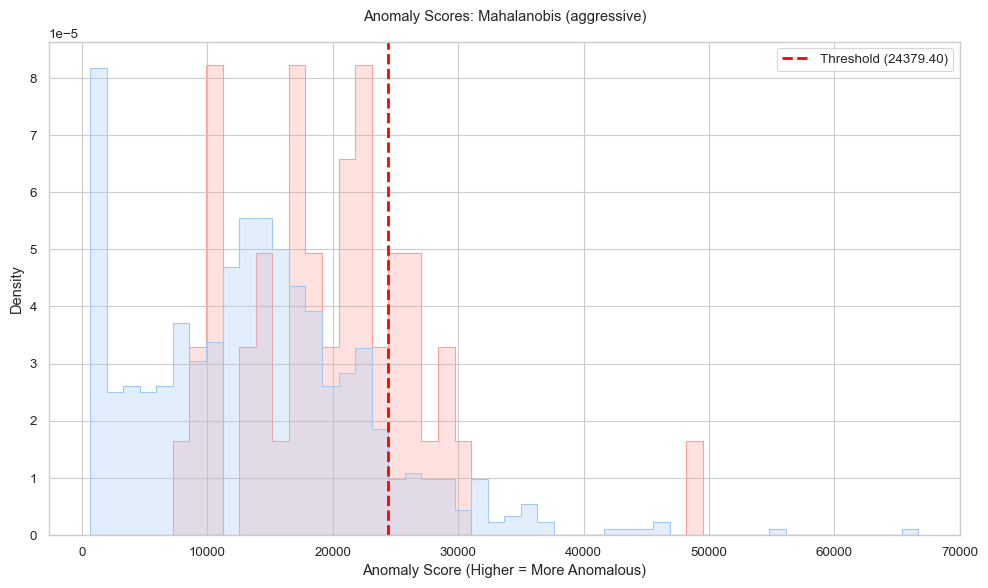

In [10]:
# 1. Anomaly Score Histogram
visualization.plot_anomaly_histogram(
    data_best['y_test'],   # <--- PRVNÍ musí být pravdivé labely (0/1)
    scores_test,           # <--- DRUHÉ musí být skóre (floaty)
    threshold=threshold,
    title=f"Anomaly Scores: {best_run['model']} ({best_run['filter']})"
)

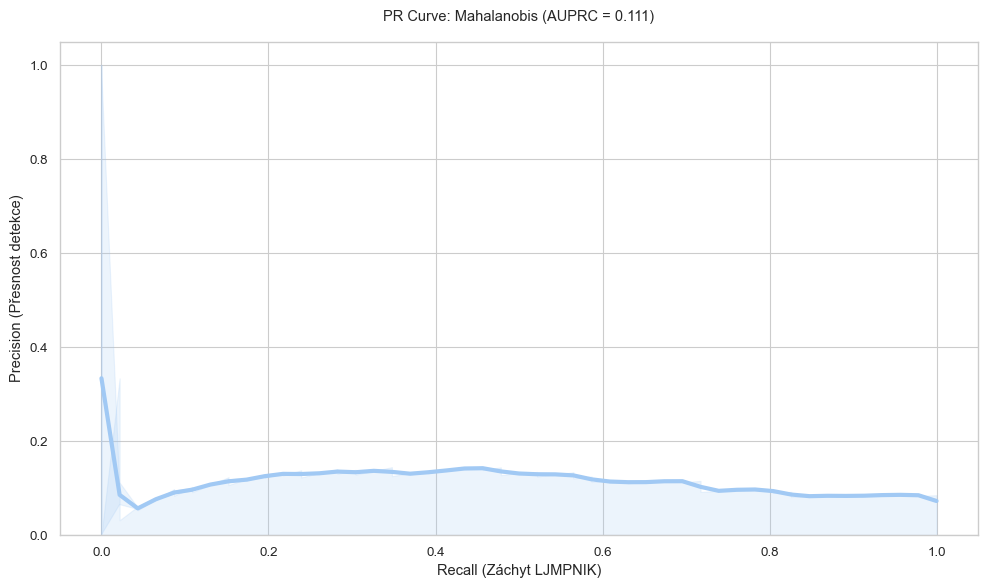

0.11119711403993475

In [11]:
# 2. Precision-Recall Curve
visualization.plot_pr_curve(
    data_best['y_test'], 
    scores_test, 
    title=f"PR Curve: {best_run['model']}"
)

In [23]:
# 3. Confusion Matrix
y_pred_test = (scores_test > threshold).astype(int)
visualization.plot_confusion_matrix_heatmap(
    data_best['y_test'], 
    y_pred_test, 
    normalize=False
)

TypeError: plot_confusion_matrix_heatmap() got an unexpected keyword argument 'normalize'

## 6. Qualitative Analysis (Export)

In [24]:
# Create comparison dataframe
df_qual = pd.DataFrame({
    'token_text': data_best['meta_test']['analyzed_token'],
    'full_text': data_best['meta_test']['text'],
    'true_label': data_best['y_test'],
    'pred_label': y_pred_test,
    'anomaly_score': scores_test,
    'document_id': data_best['meta_test']['document_id']
})

# Add Error Category
conditions = [
    (df_qual.true_label == 1) & (df_qual.pred_label == 1),
    (df_qual.true_label == 0) & (df_qual.pred_label == 0),
    (df_qual.true_label == 0) & (df_qual.pred_label == 1),
    (df_qual.true_label == 1) & (df_qual.pred_label == 0)
]
df_qual['category'] = np.select(conditions, ['TP', 'TN', 'FP', 'FN'])

# Save
qual_path = config.RESULTS_DIR / f"M1_S1_qualitative_{best_run['model']}.csv"
df_qual.to_csv(qual_path, index=False)
print(f"📝 Qualitative analysis saved to: {qual_path}")

# Show top False Positives (High score, but neutral)
print("\n❌ Top False Positives (Model thought it was anomaly, but it's not):")
show(df_qual[df_qual.category == 'FP'].sort_values('anomaly_score', ascending=False).head(10))

KeyError: 'analyzed_token'